# Travelling Salesman

This notebook tests several solutions to the travelling salesman problem. Note that the actual implementations can be found in the corresponding Python module.

_Approaches_:
* **Random**: This is not really a solution, just a weak benchmark
* **Greedy (Nearest Neighbour)**: This is a simple heuristic that actually produces a tough benchmark to beat
* **Concorde**: This is meant to be the best known solution of the TSP. I believe the algorithm itself is based on Linear Programming
* **Linear Programming**: This approach models TSP as a constraint convex optimisation problem. We define constraints (e.g. the sum of visited nodes must be equal to their number + 1), we pass a distance matrix into it and we find the minimum sum of this matrix such that all the constraints are satisfied.
* **Simulated Annealing**: SA can produces solutions that beat the greedy approach, but (1) every new set of coordinates requires parameter calibration (so you might need to run hyperparameter tuning for each set of coordinates) and (2) it tends to get more unstable as the number of coordinates goes up
* **Monte Carlo Tree Search**: The below results look pretty poor, but the algorithm can do much better than that, except it does not scale well, at least that can be said about my implementation. It also easily gets stuck in local minima early on. For a problem with 20 nodes, we begin with expanded root of length 2 (0->1, 0->2,...,0->19) and we run N simulations to estimate the expected distance of that root. There are (18-1)! possible routes from this point, so if we run 1,000,000 simulations, then we still check tiny proportion of them, nonetheless we must commit to one of these options when we finish simulating. Also, the exploration criterion is a little tough to tune if the reward is not in the 0-1 range. As for the scalability issues, the total number of simulations increases multiplicatively and each simulation requires us to aggregated the lookup table for the length of the route that we are currently considering.

On the to-do list:
* **Generic algorithm**
* **Neural Network**
* **Ant Colony Optimisation / Particle Swarm Optimisation**
* **Bayesian Optimisation**
* **Q-Learning**
* **Potentially other RL methods like SARSA or TD**
* **Come up with your own heuristic**

# Setup

In [18]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import logging
import math
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import pandas as pd
from inspect import signature
from typing import List, Dict


logging.basicConfig(level=logging.INFO)

# need to tell the interpreter where to find the module
module_dir = os.path.dirname(os.getcwd())
if module_dir not in sys.path:
    sys.path.append(module_dir)

from tsp import evaluation, coordinates, tools
from tsp.coordinates import Coordinate
from tsp.strategies import (  # these are defined in strategies.__init__
    find_path_random,
    find_path_greedy,
    find_path_sa,
    find_path_mcts,
    find_path_concorde,
    find_path_lp,
)

In [56]:
COORDINATE_DIM = 20

print(f"There are {math.factorial(COORDINATE_DIM-1)//2:,} possible routes")
# note that in the above we divide by 2 because for each tour there exists a reverse opposite, meaning that we visit
# the nodes in the same order expect that we move backwards in one version and forward in the other version

# a sample of coordinates to use for evaluation
sample_coordinates = coordinates.create_coordinates(COORDINATE_DIM)

There are 60,822,550,204,416,000 possible routes


In [57]:
strategies_to_use = [
    ("random", find_path_random, {}),
    ("greedy", find_path_greedy, {}),
    ("concorde", find_path_concorde, {}),
    ("lp", find_path_lp, {}),
    ("sa", find_path_sa, {"iterations": 100000, "temperature_scale": 150, "cooling": 0.0025}),
    ("mcts", find_path_mcts, {"sims": 10, "exploration_criterion": 10})
]

# paths built with various solutions (this may take a while to run)
paths = {
    label: tools.timer(strategy)(sample_coordinates, **argdict) 
    for label, strategy, argdict in strategies_to_use
}

# distance + time
solutions = {
    label: (evaluation.get_total_distance(contents.result.path), contents.elapsed) 
    for label, contents in paths.items()
}

INFO:tsp.strategies.random:finding a random path...
INFO:tsp.strategies.greedy:finding a greedy path...
INFO:tsp.strategies.concorde:Finding a path using the Concorde algorithm...
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
INFO:tsp.strategies.lp:finding a path based on linear programming...
Fractional matching routine failed
No warmstart, stumbling on anyway


Problem Name: TSP
Problem Type: TSP
Number of Nodes: 20
Geographical Norm in Meters (CC_GEOM)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Setting kick type to close
Starting Cycle: 559908
   0 Steps   Best: 498577   0.00 seconds
  10 Total Steps.
Best cycle length: 498577
Lin-Kernighan Running Time: 0.00
LK Initial Run: 498577.0
LK Run 0: 498577.0
LK Run from best tour: 498577.0
Time to find compression tour: 0.00 (seconds)
Set initial upperbound to 498577 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 439387.000000  (0.00 seconds)
  LP Value  2: 494372.500000  (0.00 seconds)
  LP Value  3: 498577.000000  (0.01 seconds)
New lower bound: 498577.000000
Exact lower bound: 498577.000000
DIFF: 0.000000
Established Bound: 498577
Optimal tour: 498577
Total Time to solve TSP: 0.02


INFO:tsp.strategies.sa:Finding a path using the SA algorithm...


Long-step dual simplex will be used


INFO:tsp.strategies.mcts:Finding a path using the MCTS algorithm...


# Explore solutions

## Chosen paths

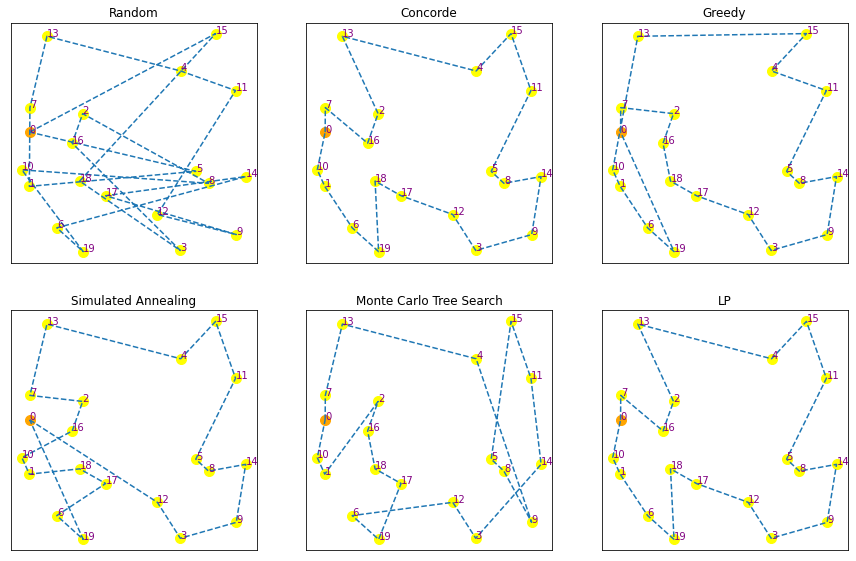

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

In [58]:
# Explore the paths
plt.close('all')
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
gs = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])
evaluation.plot_destinations(paths["random"].result.path, "Random", ax1)
evaluation.plot_destinations(paths["concorde"].result.path, "Concorde", ax2)
evaluation.plot_destinations(paths["greedy"].result.path, "Greedy", ax3)
evaluation.plot_destinations(paths["sa"].result.path, "Simulated Annealing", ax4)
evaluation.plot_destinations(paths["mcts"].result.path, "Monte Carlo Tree Search", ax5)
evaluation.plot_destinations(paths["lp"].result.path, "LP", ax6)

## Distance and time comparisons

Text(0.5, 0, 'Time in seconds')

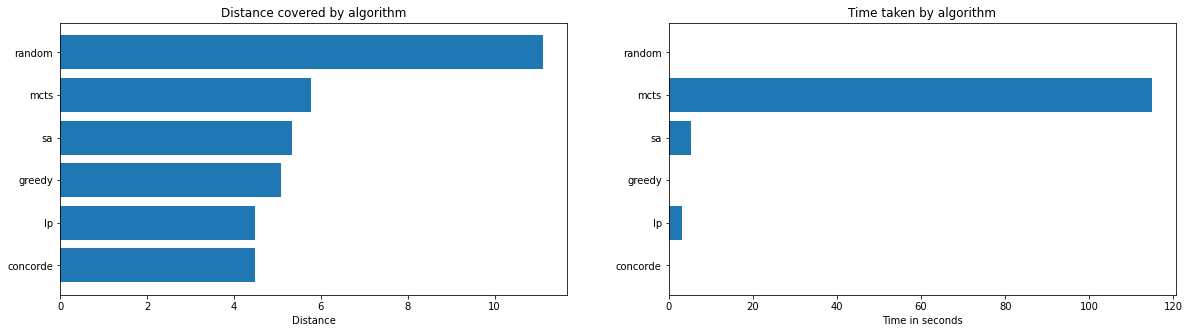

In [61]:
performance_results = (
    pd.DataFrame
    .from_dict(solutions)
    .join(pd.DataFrame({"measure": ["distance","time"]}))
    .melt(id_vars="measure", value_vars=solutions.keys())
    .pivot(index="variable", columns="measure", values="value")
    .reset_index()
    .rename(columns={"variable": "algorithm"})
    .sort_values("distance")
)

plt.close('all')
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(20)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax1.barh(performance_results["algorithm"], performance_results["distance"])
#ax1.bar_label(ax1.containers[0])
ax1.set_title("Distance covered by algorithm")
ax1.set_xlabel("Distance")
ax2.barh(performance_results["algorithm"], performance_results["time"])
#ax2.bar_label(ax2.containers[0])
ax2.set_title("Time taken by algorithm")
ax2.set_xlabel("Time in seconds")

# Performance history of iterative solutions

Text(0.5, 1.0, 'MCTS History')

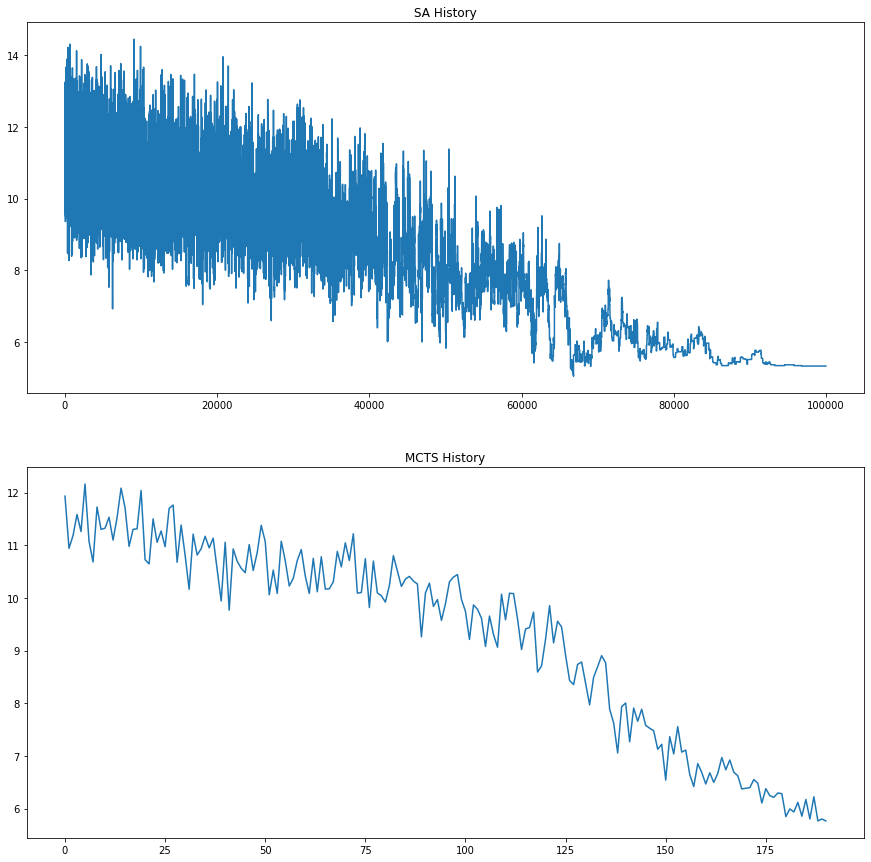

In [62]:
plt.close('all')
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax1.plot(paths["sa"].result.history)
ax1.set_title("SA History")
ax2.plot(paths["mcts"].result.history)
ax2.set_title("MCTS History")